In [45]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from jax import config
import os, sys
config.update("jax_enable_x64", True)
import pickle
import time
from pathlib import Path
project_root = Path().resolve()              # e.g. /workspaces/TIME_DOMAIN_WORK
simphony_path = project_root / "simphony"    # relative clone folder
sys.path.insert(0, str(simphony_path))
import simphony
from scipy import signal

from simphony.libraries import siepic,ideal
from simphony.time_domain.ideal import Modulator
from simphony.time_domain.simulation import TimeResult, TimeSim
from simphony.time_domain.utils import gaussian_pulse, smooth_rectangular_pulse
from scipy.integrate import solve_ivp
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d


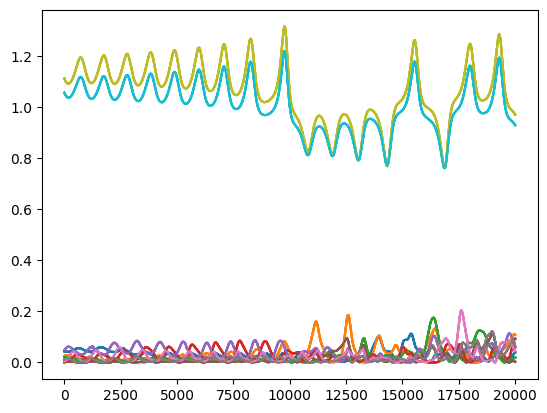

In [77]:
data = np.load("X_mmi_binary_final.npz")
X_re    = data["X_re"]
X_im    = data["X_im"]
y = data["labels"]
y_data = np.asarray(y, dtype=float)
X_data    = X_re + 1j * X_im  
plt.plot(np.abs(X_data[0:20000])**2)
plt.show()

In [64]:
## Lorenz-63 parameters
sigma, rho, beta = 10.0, 28.0, 8/3

def lorenz(t, xyz):
    x, y, z = xyz
    return [sigma*(y - x),
            x*(rho - z) - y,
            x*y - beta*z]

# --- integration settings ---------------------------------
dt          = 0.05                   #   Δt used in the paper
n_train     = 400                   #   per variable
n_test      = 601
n_warmup    = 100                    #   let the attractor settle first
total_steps = n_warmup + n_train + n_test   # = 1100
t_eval      = np.linspace(0,
                          dt*total_steps,
                          total_steps)
sol = solve_ivp(lorenz,
                (0, t_eval[-1]),
                (0., 1., 1.05),          # same IC as the paper
                t_eval=t_eval,
                method="RK45")
xyz = sol.y.T 
x, y, z = xyz.T                  # shape (1101, 3)
x   = x[n_warmup:]
y_  = y[n_warmup:]
z_  = z[n_warmup:]

def minmax(u):
    return 2 *(u - u.min())/(u.max() - u.min()) - 1

N_coarse  = 1001 
t_coarse  = np.arange(N_coarse) * dt
upsample  = 80                  # 1→10
dt_fine   = dt/ upsample # 0.005
N_fine    = N_coarse * upsample  # 10 000

t_fine = np.linspace(0.0, t_coarse[-1], N_fine) 

cs = CubicSpline(t_coarse, x)
x_f = cs(t_fine)                              # length 10 000
y_f = CubicSpline(t_coarse, y_)(t_fine)
z_f = CubicSpline(t_coarse, z_)(t_fine)

signal = minmax(x_f)
signal2 = minmax(y_f)
y = minmax(z_f)


--- Passive Sub-Netlist 0 ---

Instances: {'yb8': 'y_branch', 'yb6': 'y_branch', 'yinput': 'y_branch', 'wg4': 'waveguide', 'wg7': 'waveguide', 'yb1': 'y_branch', 'wg3': 'waveguide', 'wg9': 'waveguide', 'yb4': 'y_branch', 'wg10': 'waveguide', 'wg8': 'waveguide', 'yb5': 'y_branch', 'wg6': 'waveguide', 'yb7': 'y_branch', 'wg5': 'waveguide', 'yb2': 'y_branch', 'yb3': 'y_branch', 'wg2': 'waveguide'}

Connections: {'yinput,port_1': 'yb1,port_1', 'yb1,port_2': 'yb2,port_1', 'yb1,port_3': 'yb3,port_1', 'yb2,port_2': 'yb4,port_1', 'yb2,port_3': 'yb5,port_1', 'yb3,port_2': 'yb6,port_1', 'yb3,port_3': 'yb7,port_1', 'yb4,port_2': 'wg2,o0', 'yb4,port_3': 'wg3,o0', 'yb5,port_2': 'wg4,o0', 'yb5,port_3': 'wg5,o0', 'yb6,port_2': 'wg6,o0', 'yb6,port_3': 'wg7,o0', 'yb7,port_2': 'yb8,port_1', 'yb7,port_3': 'wg8,o0', 'yb8,port_2': 'wg9,o0', 'yb8,port_3': 'wg10,o0'}

Ports: {'o0': 'yinput,port_2', 'o1': 'yinput,port_3', 'o2': 'wg2,o1', 'o3': 'wg3,o1', 'o4': 'wg4,o1', 'o5': 'wg5,o1', 'o6': 'wg6,o1', 'o7': '

/workspaces/time_domain_work/simphony/simphony/time_domain/pole_residue_model.py:125: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  weights, _, _, _ = np.linalg.lstsq(M, B)



--- Final Time-Domain Netlist ---

Models: {'0': <simphony.time_domain.time_system.TimeSystemIIR object at 0x73606cede600>}

Connections: {}

Ports: {'o0': '0,o0', 'o1': '0,o1', 'o2': '0,o2', 'o3': '0,o3', 'o4': '0,o4', 'o5': '0,o5', 'o6': '0,o6', 'o7': '0,o7', 'o8': '0,o8', 'o9': '0,o9', 'o10': '0,o10'}



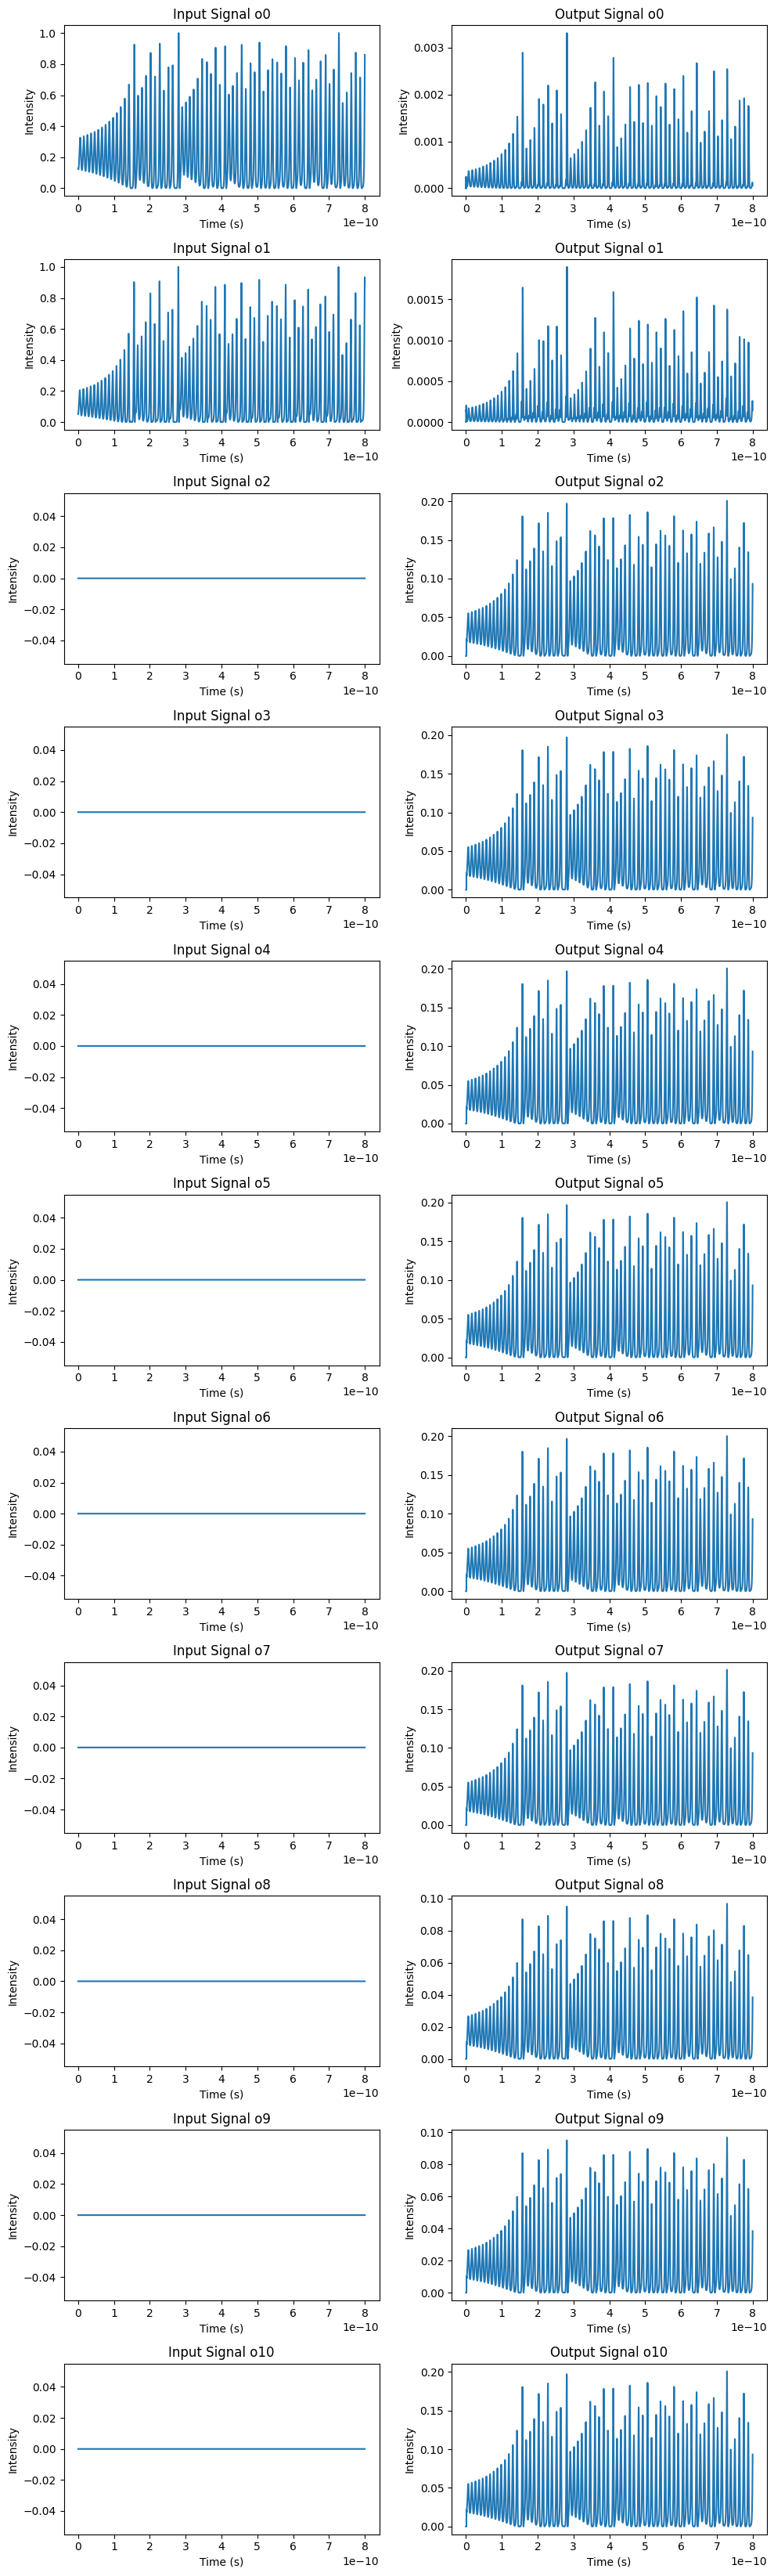

In [78]:
splitter_netlist = {
    "instances":{
        # "wg1": "waveguide",
        "wg2": "waveguide",
        "wg3": "waveguide",
        "wg4": "waveguide",
        "wg5": "waveguide",
        "wg6": "waveguide",
        "wg7": "waveguide",
        "wg8": "waveguide",
        "wg9": "waveguide",
        "wg10": "waveguide",

        "yinput":"y_branch",
        "yb1": "y_branch",
        "yb2": "y_branch",
        "yb3": "y_branch",
        "yb4": "y_branch",
        "yb5": "y_branch",
        "yb6": "y_branch",
        "yb7": "y_branch",
        "yb8": "y_branch",
    },
    "connections":{

        "yinput,port_1":"yb1,port_1",
        "yb1,port_2":"yb2,port_1",
        "yb1,port_3":"yb3,port_1",

        "yb2,port_2":"yb4,port_1",
        "yb2,port_3":"yb5,port_1",
        "yb3,port_2":"yb6,port_1",
        "yb3,port_3":"yb7,port_1",

        "yb4,port_2":"wg2,o0",
        "yb4,port_3":"wg3,o0",
        "yb5,port_2":"wg4,o0",
        "yb5,port_3":"wg5,o0",
        "yb6,port_2":"wg6,o0",
        "yb6,port_3":"wg7,o0",

        "yb7,port_2":"yb8,port_1",
        "yb7,port_3":"wg8,o0",
        "yb8,port_2":"wg9,o0",
        "yb8,port_3":"wg10,o0",


    },
    "ports":{
        "o0":"yinput,port_2",
        "o1":"yinput,port_3",
        "o2":"wg2,o1",
        "o3":"wg3,o1",
        "o4":"wg4,o1",
        "o5":"wg5,o1",
        "o6":"wg6,o1",
        "o7":"wg7,o1",
        "o8":"wg8,o1",
        "o9":"wg9,o1",
        "o10":"wg10,o1",


    },
}
T = 80e-11
dt = 1e-14                   # Time step/resolution
t = jnp.arange(0, T, dt)
num_measurements = 200
wvl = np.linspace(1.5, 1.6, num_measurements)
options = {
    'wl': wvl,
    'wg1': {'length': 10.0},
    'wg2': {'length': 50.0},
    'wg3': {'length': 50.0},
    'wg4': {'length': 50.0},
    'wg5': {'length': 50.0},
    'wg6': {'length': 50.0},
    'wg7': {'length': 50.0},
    'wg8': {'length': 50.0},
    'wg9': {'length': 50.0},
    'wg10': {'length': 50.0},
    
}
# MultiModeInterferometer = MMI(r=10, s=10)
MultiModeInterferometer = ideal.make_mmi_model(r = 10, s = 10)
models = {
    "waveguide": siepic.waveguide,
    "y_branch": siepic.y_branch,
    "MultiModeInterferometer": MultiModeInterferometer,
}
c = 299792458.0
final_sim_split = TimeSim(netlist = splitter_netlist, models = models, settings= options) 
result = final_sim_split.run(t, {
    "o0":signal[:len(t)],
    'o1': signal2[:len(t)],
    'o2': jnp.zeros_like(t),
    'o3': jnp.zeros_like(t),
    'o4': jnp.zeros_like(t),
    'o5': jnp.zeros_like(t),
    'o6': jnp.zeros_like(t),
    'o7': jnp.zeros_like(t),
    'o8': jnp.zeros_like(t),
    'o9': jnp.zeros_like(t),
    'o10': jnp.zeros_like(t),
    }, carrier_freq=c/(1.55*1e-6), dt=dt)

result.plot_sim()


In [110]:
num_delay = 100

T =10e-11
dt = 1e-14                   # Time step/resolution
t = jnp.arange(0, T, dt)
num_measurements = 200
wvl = np.linspace(1.5, 1.6, num_measurements)
options = {
    'wl': wvl,
    'wg1': {'length': 10.0},
    'wg2': {'length': 50.0},
    'wg3': {'length': 50.0},
    'wg4': {'length': 50.0},
    'wg5': {'length': 50.0},
    'wg6': {'length': 50.0},
    'wg7': {'length': 50.0},
    'wg8': {'length': 50.0},
    'wg9': {'length': 50.0},
    'wg10': {'length': 50.0},
    
}
final_sim_groups = []
for k in range(0,2):
    group_delay = []
    group_delay_ts = []
    for i in range(0, num_delay//5):
        netlist = {}
        netlist["instances"] = {}
        netlist["connections"] = {}
        netlist["ports"] = {}
        for j in range(2, 7):
            netlist["instances"][f"wg{j}"] = "waveguide"
        netlist["ports"]["o0"] = "wg2,o0"
        netlist["ports"]["o1"] = "wg6,o1"

        for j in range(2, 6):
            netlist["connections"][f"wg{j},o1"] = f"wg{j+1},o0"
        group_delay.append(netlist)

    models = {
        "waveguide": siepic.waveguide,
        "y_branch": siepic.y_branch,
    }

    for netlist in group_delay:
        sim = TimeSim(netlist = netlist, models = models, settings = options)
        group_delay_ts.append(sim)

    final_netlist = {
        "instances":{},
        "connections":{},
        "ports":{},
    }

    counter = 0
    final_netlist["ports"]["o0"] = f"time_sim{counter},o0"

    for i, time_sim in enumerate(group_delay_ts[:-1]):
        final_netlist["instances"][f"time_sim{counter}"] = f"time_sim{counter}"
        models[f"time_sim{counter}"] = time_sim
        final_netlist["connections"][f"time_sim{counter},o1"] = f"time_sim{counter+1},o0"
        counter +=1
    models[f"time_sim{counter}"] = group_delay_ts[-1]
    final_netlist["instances"][f"time_sim{counter}"] = f"time_sim{counter}"
    final_netlist["ports"]["o1"] = f"time_sim{counter},o1"
    l = 0
    final_sim = TimeSim(netlist= final_netlist, models= models, settings=options)
    final_sim_groups.append(final_sim)


In [111]:
mmi_netlist = {
    "instances":{
        "mmi": "MultiModeInterferometer",
        "wg1": "waveguide",

    },
    "connections":{
        "mmi,o0":"wg1,o1",

    },
    "ports":{
        
        "o0":"wg1,o0",
        "o1":"mmi,o1",
        "o2":"mmi,o2",
        "o3":"mmi,o3",
        "o4":"mmi,o4",
        "o5":"mmi,o5",
        "o6":"mmi,o6",
        "o7":"mmi,o7",
        "o8":"mmi,o8",
        "o9":"mmi,o9",
        
        "o10":"mmi,o10",
        "o11":"mmi,o11",
        "o12":"mmi,o12",
        "o13":"mmi,o13",
        "o14":"mmi,o14",
        "o15":"mmi,o15",
        "o16":"mmi,o16",
        "o17":"mmi,o17",
        "o18":"mmi,o18",
        "o19":"mmi,o19",

    },
}
MultiModeInterferometer = ideal.make_mmi_model(r = 10, s = 10)
models = {
    "waveguide": siepic.waveguide,
    "y_branch": siepic.y_branch,
    "MultiModeInterferometer": MultiModeInterferometer,
}
mmi_sim = TimeSim(netlist = mmi_netlist, models=models, settings= options)

In [112]:
combined_netlist = {
    "instances":{},
    "connections":{},
    "ports":{},
}
combined_netlist["instances"]["final_sim0"] = "final_sim0"
combined_netlist["instances"]["final_sim1"] = "final_sim1"
combined_netlist["instances"]["final_sim_split"] = "final_sim_split1"
combined_netlist["instances"]["mmi_sim"] = "mmi_simmer"
models_combined = {
    "final_sim0": final_sim_groups[0],
    "final_sim1": final_sim_groups[1],
    "final_sim_split1":final_sim_split,
    "mmi_simmer":mmi_sim,
}
combined_netlist["connections"]["final_sim0,o0"] = "final_sim_split,o10"
combined_netlist["connections"]["final_sim1,o0"] = "final_sim_split,o9"
for i in range(0,9):
    combined_netlist["ports"][f"o{i}"] = f"final_sim_split,o{i}"
combined_netlist["ports"]["o9"] = "final_sim1,o1"
combined_netlist["ports"]["o10"] = "final_sim0,o1"
print(combined_netlist)




combined_netlist_mmi = {
    "instances":{},
    "connections":{},
    "ports":{},
}
combined_netlist_mmi["instances"]["final_sim_split"] = "final_sim_split1"
combined_netlist_mmi["instances"]["mmi_simmer"] = "mmi_simmer"
models_combined_mmi = {
    "final_sim_split1":final_sim_split,
    "mmi_simmer":mmi_sim,
}
for i in range(2,11):
    combined_netlist_mmi["connections"][f"mmi_simmer,o{i-1}"] = f"final_sim_split,o{i}"
combined_netlist_mmi["ports"]["o0"] = "final_sim_split,o0"
combined_netlist_mmi["ports"]["o1"] = "final_sim_split,o1"
for i in range(10,20):
    combined_netlist_mmi["ports"][f"o{i-7}"] = f"mmi_simmer,o{i}"
combined_netlist_mmi["ports"]["o2"] = "mmi_simmer,o0"

print(combined_netlist_mmi)

{'instances': {'final_sim0': 'final_sim0', 'final_sim1': 'final_sim1', 'final_sim_split': 'final_sim_split1', 'mmi_sim': 'mmi_simmer'}, 'connections': {'final_sim0,o0': 'final_sim_split,o10', 'final_sim1,o0': 'final_sim_split,o9'}, 'ports': {'o0': 'final_sim_split,o0', 'o1': 'final_sim_split,o1', 'o2': 'final_sim_split,o2', 'o3': 'final_sim_split,o3', 'o4': 'final_sim_split,o4', 'o5': 'final_sim_split,o5', 'o6': 'final_sim_split,o6', 'o7': 'final_sim_split,o7', 'o8': 'final_sim_split,o8', 'o9': 'final_sim1,o1', 'o10': 'final_sim0,o1'}}
{'instances': {'final_sim_split': 'final_sim_split1', 'mmi_simmer': 'mmi_simmer'}, 'connections': {'mmi_simmer,o1': 'final_sim_split,o2', 'mmi_simmer,o2': 'final_sim_split,o3', 'mmi_simmer,o3': 'final_sim_split,o4', 'mmi_simmer,o4': 'final_sim_split,o5', 'mmi_simmer,o5': 'final_sim_split,o6', 'mmi_simmer,o6': 'final_sim_split,o7', 'mmi_simmer,o7': 'final_sim_split,o8', 'mmi_simmer,o8': 'final_sim_split,o9', 'mmi_simmer,o9': 'final_sim_split,o10'}, 'ports

In [113]:
c = 299792458.0
combined_sim = TimeSim(netlist=combined_netlist_mmi, models= models_combined_mmi, settings= options)
results =mmi_sim.run(t, input_signals={
    # "o0": signal[:len(t)],
    # 'o1': signal2[:len(t)],
    # 'o2': smooth_rectangular_pulse(t, 0.0, T+ 20.0e-11)*jnp.sqrt(10),
    'o0': smooth_rectangular_pulse(t,0.0, T+ 20.0e-11)*jnp.sqrt(10),
    'o1': jnp.zeros_like(t),
    'o2': jnp.zeros_like(t),
    'o3': jnp.zeros_like(t),
    'o4': jnp.zeros_like(t),
    'o5': jnp.zeros_like(t),
    'o6': jnp.zeros_like(t),
    'o7': jnp.zeros_like(t),
    'o8': jnp.zeros_like(t),
    'o9': jnp.zeros_like(t),
    'o10': jnp.zeros_like(t),
    'o11': jnp.zeros_like(t),
    'o12': jnp.zeros_like(t),
    'o13': jnp.zeros_like(t),
    'o14': jnp.zeros_like(t),
    'o15': jnp.zeros_like(t),
    'o16': jnp.zeros_like(t),
    'o17': jnp.zeros_like(t),
    'o18': jnp.zeros_like(t),
    'o19': jnp.zeros_like(t),
    }, carrier_freq=c/(1.55*1e-6), dt=dt)



--- Passive Sub-Netlist 0 ---

Instances: {'mmi': 'MultiModeInterferometer', 'wg1': 'waveguide'}

Connections: {'mmi,o0': 'wg1,o1'}

Ports: {'o0': 'wg1,o0', 'o1': 'mmi,o1', 'o2': 'mmi,o2', 'o3': 'mmi,o3', 'o4': 'mmi,o4', 'o5': 'mmi,o5', 'o6': 'mmi,o6', 'o7': 'mmi,o7', 'o8': 'mmi,o8', 'o9': 'mmi,o9', 'o10': 'mmi,o10', 'o11': 'mmi,o11', 'o12': 'mmi,o12', 'o13': 'mmi,o13', 'o14': 'mmi,o14', 'o15': 'mmi,o15', 'o16': 'mmi,o16', 'o17': 'mmi,o17', 'o18': 'mmi,o18', 'o19': 'mmi,o19'}



/workspaces/time_domain_work/simphony/simphony/time_domain/pole_residue_model.py:125: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  weights, _, _, _ = np.linalg.lstsq(M, B)



--- Final Time-Domain Netlist ---

Models: {'0': <simphony.time_domain.time_system.TimeSystemIIR object at 0x73606a4d7890>}

Connections: {}

Ports: {'o0': '0,o0', 'o1': '0,o1', 'o2': '0,o2', 'o3': '0,o3', 'o4': '0,o4', 'o5': '0,o5', 'o6': '0,o6', 'o7': '0,o7', 'o8': '0,o8', 'o9': '0,o9', 'o10': '0,o10', 'o11': '0,o11', 'o12': '0,o12', 'o13': '0,o13', 'o14': '0,o14', 'o15': '0,o15', 'o16': '0,o16', 'o17': '0,o17', 'o18': '0,o18', 'o19': '0,o19'}



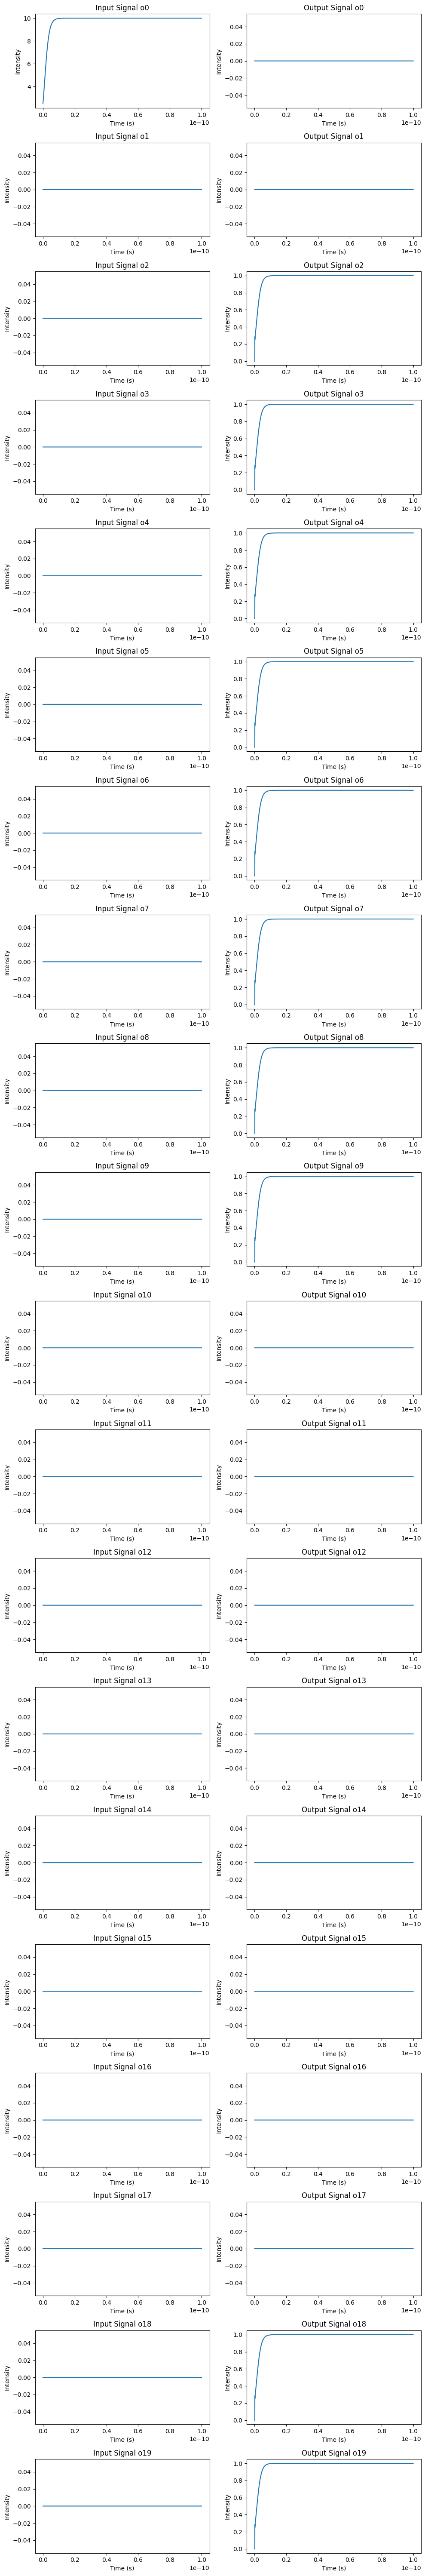

In [114]:
results.plot_sim()